### PCA 

This notebook incorporates two Principal Component analyses performed on the examined trajectory. The first is a rather standard backbone PCA performed by MDTraj while the second one is a full atom - positions only PCA focused on recreating an Energy landscape explored by the system. 

In [1]:
# import all needed libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
import seaborn as sns
import math
import plotly.express as px 
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis.align import AlignTraj
import nglview
import os
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
#load the trajectory
GRO = '../step1_pdbreader.pdb'
XTC = '../md_noPBC.xtc'

rec_traj = mda.Universe(str(GRO),str(XTC))
rec_ref = mda.Universe(str(GRO),str(XTC))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


To align the trajectory we use the AlignTraj command.
However, since the command can take a while, we can save it's output on a .DCD file and then we can load the aligned trajectory directly.


In [3]:
aligner = AlignTraj(rec_traj, rec_ref, select='name CA',filename=str('md_aligned.DCD'))
aligner.run()

In [4]:
#Now we create a new universe with the aligned trajectory
rec_alignd = mda.Universe(str(GRO),str('md_aligned.DCD'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [5]:
rec_pca = PCA(rec_alignd, select='backbone')
rec_pca.run()

In [6]:
rec_pca.cumulated_variance

fig = px.line(x=np.arange(rec_pca.cumulated_variance.shape[0]),
        y=rec_pca.cumulated_variance,
       labels={'x':'Components','y':'Cumulated Variance'},
       title="Variance retained per Principal Component",
       range_x=[0,50])

fig.show()
fig.write_image("Cumulated_Variance.pdf") 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/MDAnalysis/analysis/pca.py:346: DeprecationWarning: The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [7]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

pca_space = rec_pca.transform(rec_alignd.select_atoms('backbone'), 3)

# Since MDAnalysis expresses the displacement in angstrom, we need to multiply the coefficients by 0.1 to get the displacements in nm

By hovering over the plot above we can deduce the percentage(%) of the motion captured cumulatively by X components. We can focus on the first X components capturing the majority of the motion; ~60% could be used as a threshold.

In [8]:
pca_data = pd.DataFrame(pca_space,columns=['first_comp','second_comp','third_comp'])

In [9]:

pc1 = pca_data['first_comp']
pc2 = pca_data['second_comp']
pc3 = pca_data['third_comp']

pc1 = pc1.to_numpy()
pc2 = pc2.to_numpy()
pc3 = pc3.to_numpy()

pc1 = pc1*0.1
pc2 = pc2*0.1
pc3 = pc3*0.1


colors = np.arange(len(pc1))

In [10]:
num_of_backbone_atoms = len(rec_alignd.select_atoms('backbone'))

cosine_cont = np.zeros(num_of_backbone_atoms)
pca_space_tot = rec_pca.transform(rec_alignd.select_atoms('backbone'), num_of_backbone_atoms)

for i in range(0,len(cosine_cont)):
    cosine_cont[i] = cosine_content(pca_space_tot, i)

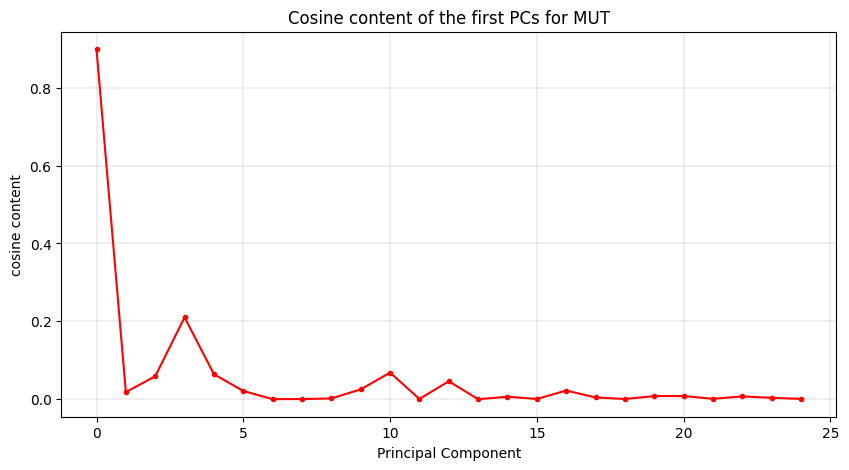

In [11]:
fig = plt.figure(figsize=(10,5))

plt.plot(cosine_cont[:25], marker='.',color='red', linestyle='-', label='Istantaneous values')
plt.title("Cosine content of the first PCs for MUT")
plt.xlabel("Principal Component")
plt.ylabel("cosine content")
plt.grid(linewidth=0.3,linestyle='-')
plt.show()

The cosine content of a principal component measures how similar it is to a cosine function, effectively measuring oscillatory behavior of the PC. Values range from 0 (no similarity to a cosine) and 1 (a perfect cosine shape). If the values of the first few principal components are close to 1, this can indicate poor sampling, as the motion of the particles may not be distinguished from random diffusion. Values below 0.7 generally do not indicate poor sampling.

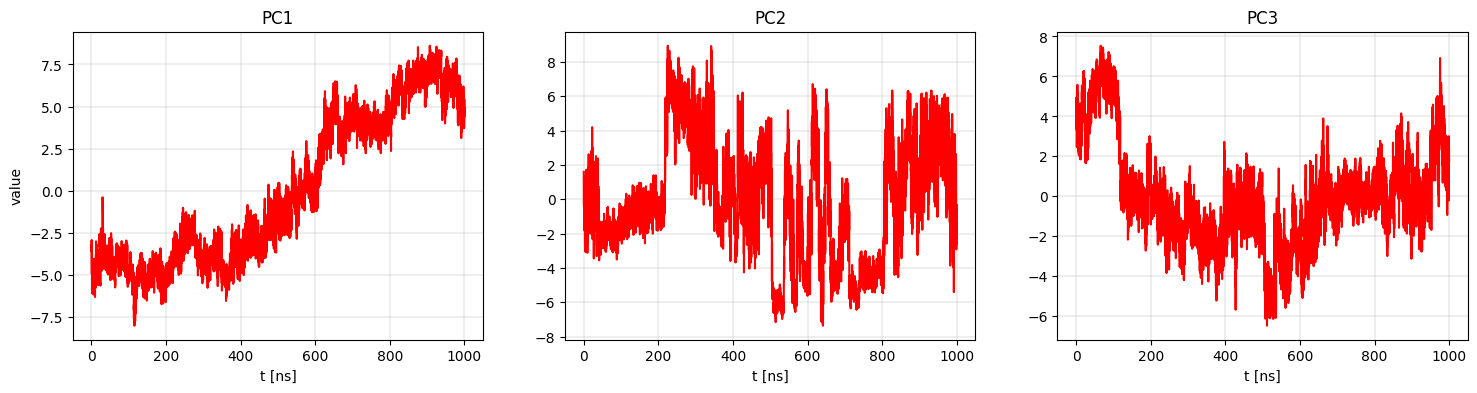

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
t = np.linspace(0, 1000, len(pc1))

ax1.plot(t,pc1,color='red', linestyle='-')
ax1.set_title("PC1")
ax1.set_xlabel("t [ns]")
ax1.set_ylabel("value")
ax1.grid(True,linewidth=0.3)

ax2.plot(t,pc2,color='red', linestyle='-')
ax2.set_title("PC2")
ax2.set_xlabel("t [ns]")
ax2.grid(True,linewidth=0.3)

ax3.plot(t,pc3,color='red', linestyle='-')
ax3.set_title("PC3")
ax3.set_xlabel("t [ns]")
ax3.grid(True,linewidth=0.3)



plt.show()

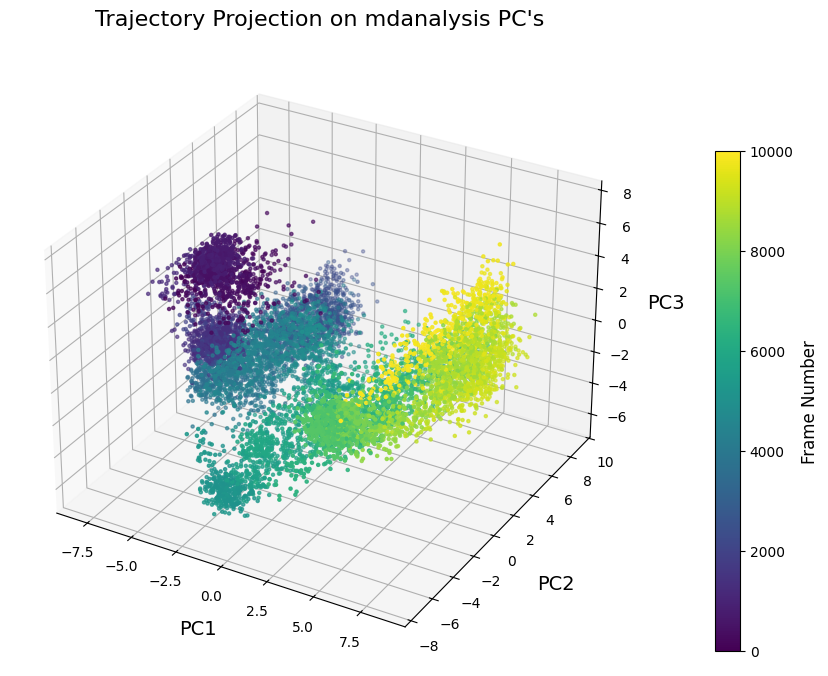

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
c=np.arange(pca_space.shape[0])

sc = ax.scatter(pc1, pc2, pc3, c=c, marker='.', cmap='viridis')  
cb = plt.colorbar(sc, ax=ax, shrink=0.6) 
cb.set_label(label='Frame Number', size = 12, labelpad = 5)
cb.ax.set_position([0.83, 0.2, 0.03, 0.5]) 

plt.title('Trajectory Projection on mdanalysis PC\'s', pad=15, fontsize = 16)
ax.set_xlabel('PC1', labelpad=10, fontsize = 14)
ax.set_ylabel('PC2', labelpad=15, fontsize = 14)
ax.set_zlabel('PC3', labelpad=10, fontsize = 14)

plt.savefig("3d_pca_mdanalysis")

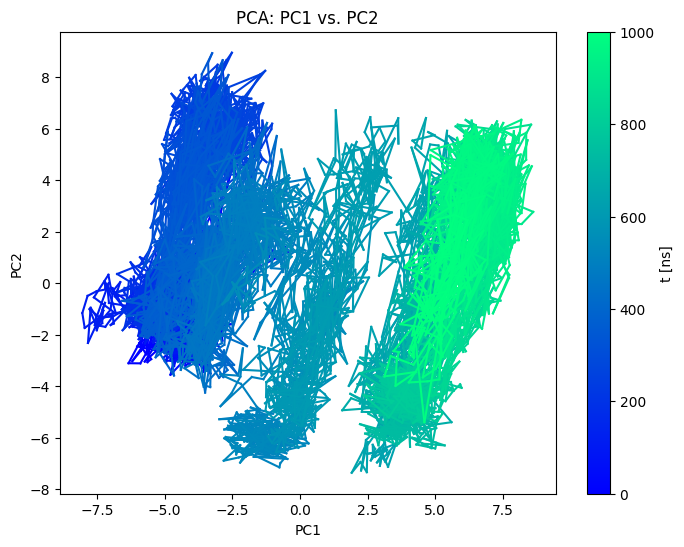

In [14]:
colors = np.linspace(0, 10000, len(pc1)) 

# Set up figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a ScalarMappable object for color scaling
norm = plt.Normalize(vmin=0, vmax=1000)  # Normalization for color mapping
sm = plt.cm.ScalarMappable(cmap='winter', norm=norm)
sm.set_array([])  # This is necessary for the colorbar to work

# Loop to plot the lines with colors based on `colors`
for i in range(len(pc1) - 1):
    plt.plot([pc1[i], pc1[i+1]], [pc2[i], pc2[i+1]], color=plt.cm.winter(colors[i]/len(pc1)), linestyle='-')

# Add title and labels
ax.set_title('PCA: PC1 vs. PC2')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='t [ns]')  # Specify the axes for the colorbar

# Show plot
plt.show()


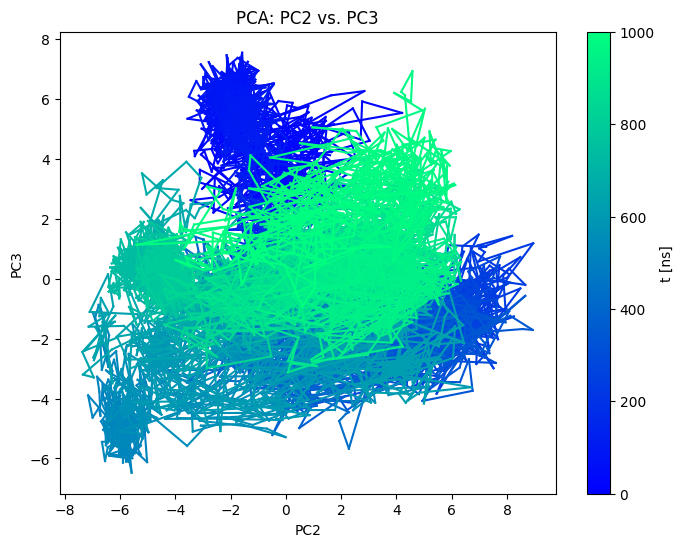

In [15]:
colors = np.linspace(0, 10000, len(pc1)) 

# Set up figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a ScalarMappable object for color scaling
norm = plt.Normalize(vmin=0, vmax=1000)  # Normalization for color mapping
sm = plt.cm.ScalarMappable(cmap='winter', norm=norm)
sm.set_array([])  # This is necessary for the colorbar to work

# Loop to plot the lines with colors based on `colors`
for i in range(len(pc1) - 1):
    plt.plot([pc2[i], pc2[i+1]], [pc3[i], pc3[i+1]], color=plt.cm.winter(colors[i]/len(pc1)), linestyle='-')

# Add title and labels
ax.set_title('PCA: PC2 vs. PC3')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='t [ns]')  # Specify the axes for the colorbar

# Show plot
plt.show()

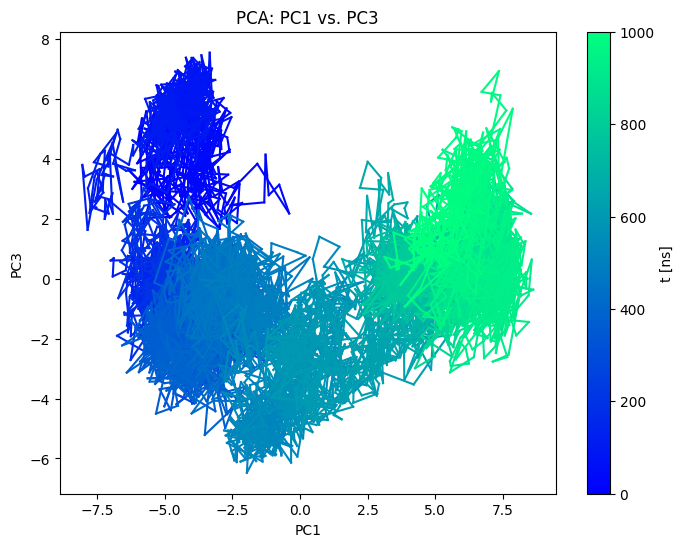

In [16]:
colors = np.linspace(0, 10000, len(pc1)) 

# Set up figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a ScalarMappable object for color scaling
norm = plt.Normalize(vmin=0, vmax=1000)  # Normalization for color mapping
sm = plt.cm.ScalarMappable(cmap='winter', norm=norm)
sm.set_array([])  # This is necessary for the colorbar to work

# Loop to plot the lines with colors based on `colors`
for i in range(len(pc1) - 1):
    plt.plot([pc1[i], pc1[i+1]], [pc3[i], pc3[i+1]], color=plt.cm.winter(colors[i]/len(pc1)), linestyle='-')

# Add title and labels
ax.set_title('PCA: PC1 vs. PC3')
ax.set_xlabel('PC1')
ax.set_ylabel('PC3')

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='t [ns]')  # Specify the axes for the colorbar

# Show plot
plt.show()

### SECOND PCA 
Here begins the second PCA

In [17]:
# Load the coordinate data
data = np.loadtxt('PCA_prep.dat')
#check if data is loaded correclty
#print(data)

In [18]:
# This block of code is essentially the pca

# Reshape data (N atoms, 3 coordinates each - x y z)
N_atoms = data.shape[1] // 3
N_frames = data.shape[0]
data = data.reshape((N_frames, N_atoms, 3))

# Flatten the coordinates for PCA
flattened_data = data.reshape(N_frames, -1)

# Center the data
mean_structure = np.mean(flattened_data, axis=0)
centered_data = flattened_data - mean_structure

# Calculate covariance matrix
covariance_matrix = np.cov(centered_data.T)

# Eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

# Sort eigenvalues and eigenvectors
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Project the data onto the first few principal components
pca_projections = np.dot(centered_data, eigenvectors[:, :3])

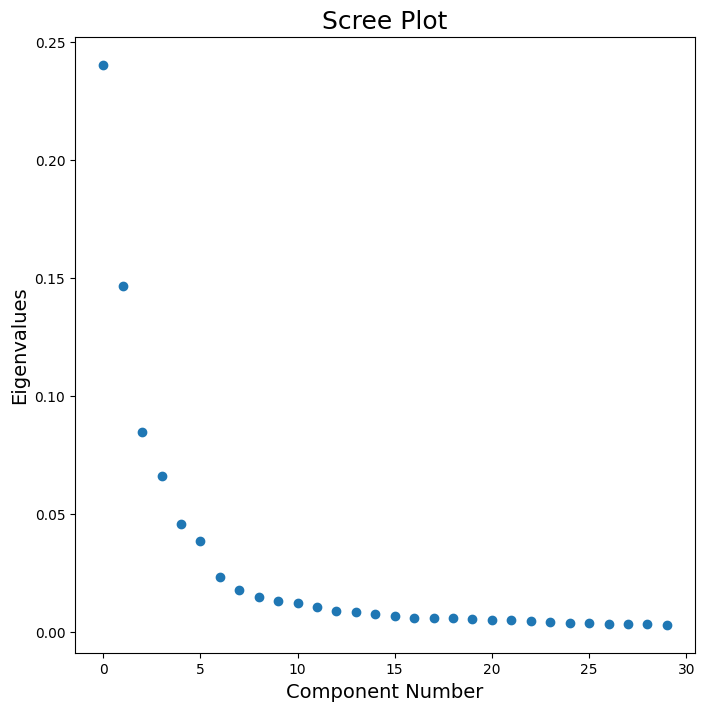

In [19]:
#Scree plot - choose how many PCs accurately describe the motion (elbow)
variance_explained = eigenvalues / np.sum(eigenvalues)

plt.figure(figsize=(8,8))
plt.plot(range(30), variance_explained[:30], 'o', linewidth=2)
plt.title('Scree Plot',fontsize = 18)
plt.xlabel('Component Number',fontsize = 14)
plt.ylabel('Eigenvalues',fontsize = 14)
plt.savefig("Scree_plot")

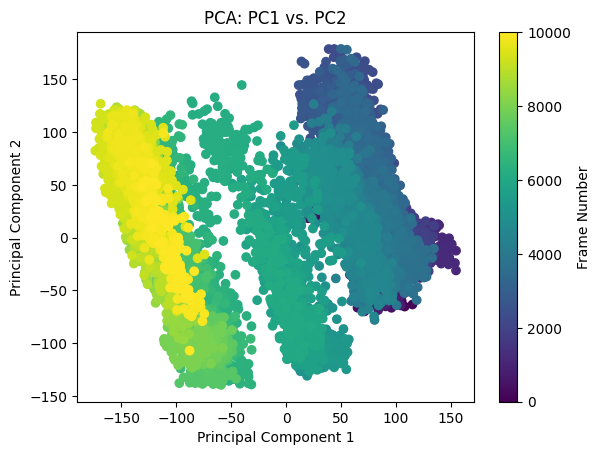

In [20]:
# Plot PC1 against PC2
plt.figure()
plt.scatter(pca_projections[:, 0], pca_projections[:, 1], c=range(N_frames), cmap='viridis')
plt.colorbar(label='Frame Number')
plt.title('PCA: PC1 vs. PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

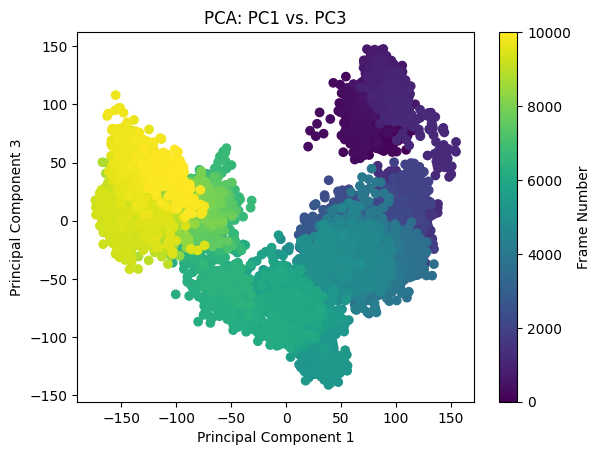

In [21]:
# Plot PC1 against PC3
plt.figure()
plt.scatter(pca_projections[:, 0], pca_projections[:, 2], c=range(N_frames), cmap='viridis')
plt.colorbar(label='Frame Number')
plt.title('PCA: PC1 vs. PC3')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.show()

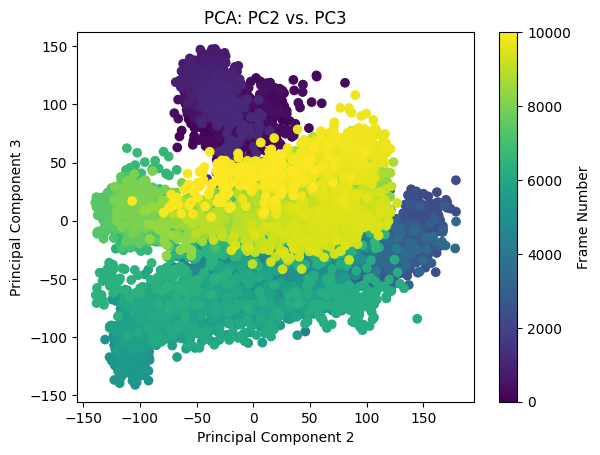

In [22]:
# Plot PC2 against PC3
plt.figure()
plt.scatter(pca_projections[:, 1], pca_projections[:, 2], c=range(N_frames), cmap='viridis')
plt.colorbar(label='Frame Number')
plt.title('PCA: PC2 vs. PC3')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.show()

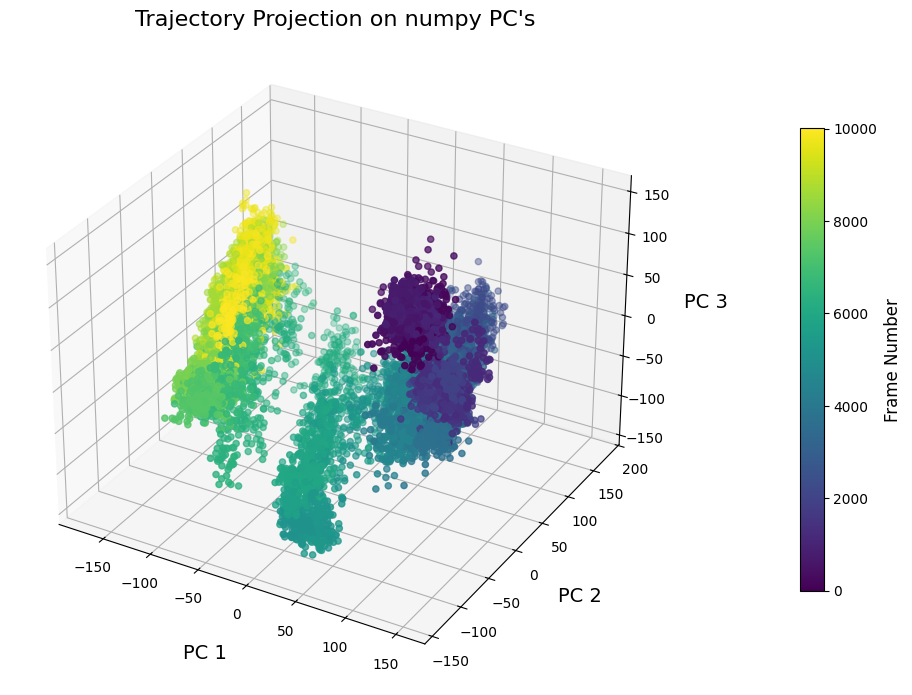

In [23]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_projections[:, 0], pca_projections[:, 1], pca_projections[:, 2], 
                     c=range(N_frames), cmap='viridis')

ax.set_title('Trajectory Projection on numpy PC\'s',fontsize = 16)
ax.set_xlabel('PC 1',labelpad = 15,fontsize = 14)
ax.set_ylabel('PC 2',labelpad = 15,fontsize = 14)
ax.set_zlabel('PC 3',labelpad = 15,fontsize = 14)
fig.colorbar(scatter, shrink=0.5, pad = 0.15).set_label(label='Frame Number', size=12, labelpad=5)
plt.savefig("3d_pca_homemade")

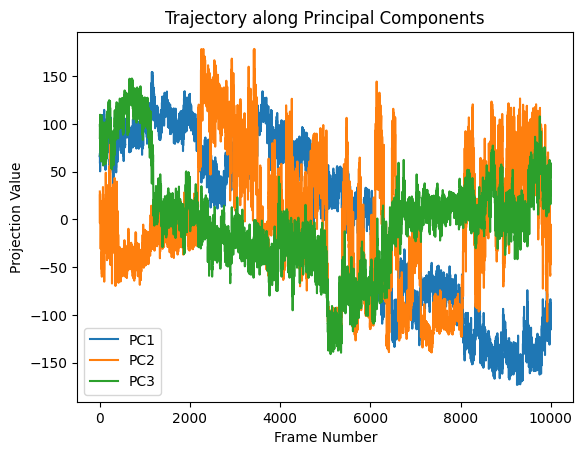

In [24]:
# visualize the time evolution of the system along a particular principal component.
plt.figure()
plt.plot(range(N_frames), pca_projections[:, 0], label='PC1')
plt.plot(range(N_frames), pca_projections[:, 1], label='PC2')
plt.plot(range(N_frames), pca_projections[:, 2], label='PC3')
plt.xlabel('Frame Number')
plt.ylabel('Projection Value')
plt.title('Trajectory along Principal Components')
plt.legend()
plt.show()

In [25]:
# 2D histogram of the projections
x = pca_projections[:, 0]
y = pca_projections[:, 1]

# Estimate the density (similar to a free energy landscape - let's hope)
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Calculate free energy using the Boltzmann relation: E = -k_B * T * ln(P)
# T is the temperature of the simulation in Kelvin
T = 303.15
constant = 1.380649*T
free_energy = -np.log(z)*constant

# Create a grid for plotting
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = gaussian_kde(xy)(np.vstack([xi.flatten(), yi.flatten()]))
free_energy_grid = -np.log(zi).reshape(xi.shape)

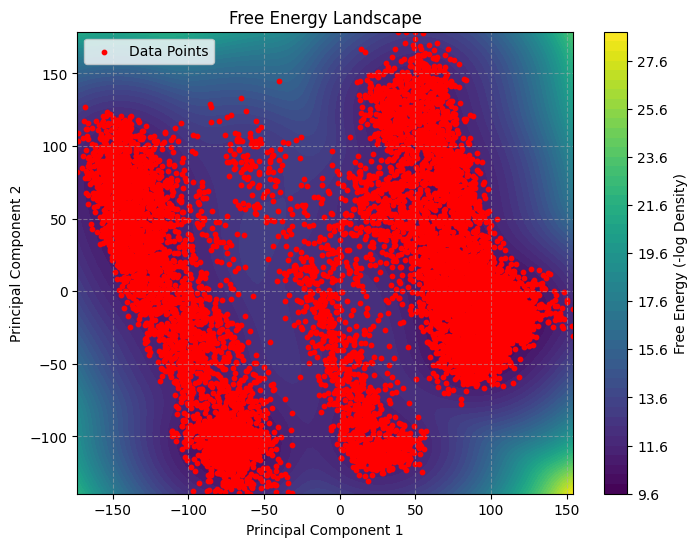

In [26]:
# Plot free energy as a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(xi, yi, free_energy_grid, levels=50, cmap='viridis')
plt.colorbar(label="Free Energy (-log Density)")
plt.scatter(x, y, color='red', s=10, label="Data Points")
plt.title("Free Energy Landscape")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

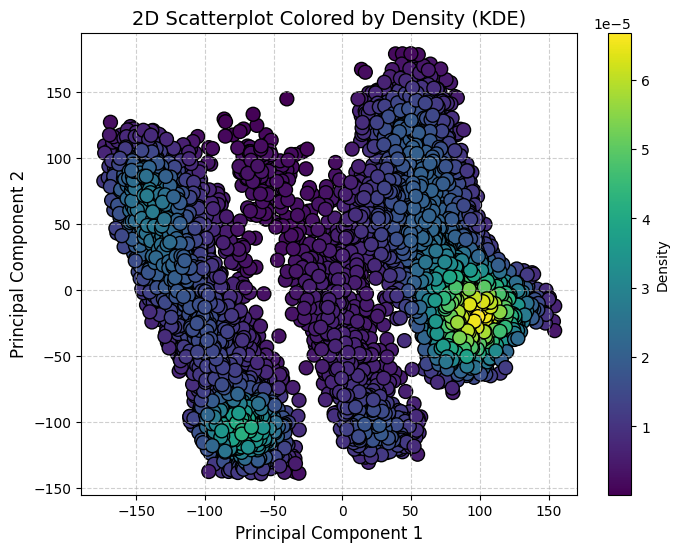

In [27]:
kde = gaussian_kde(xy)
z2 = kde(xy)  # Density values at the given points

# Create scatterplot, coloring by density
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=z2, cmap='viridis', s=100, edgecolor='k')
plt.title("2D Scatterplot Colored by Density (KDE)", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.colorbar(label="Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [28]:
# Flatten the grid and free energy values
x_flat = xi.flatten()
y_flat = yi.flatten()
z_flat = free_energy_grid.flatten()

# Create a DataFrame
data = pd.DataFrame({
    'x': x_flat,
    'y': y_flat,
    'free_energy': z_flat
})

# Use Plotly to create a 3D scatter plot
fig = px.scatter_3d(data, x='x', y='y', z='free_energy', color='free_energy', color_continuous_scale=px.colors.sequential.Plasma[::-1],
                    title='3D \'Free\' Energy Landscape', labels={'free_energy': 'Energy'})
fig.write_html("interactive_plot_3dEnergy.html")

(10002, 3)
[[ 66.11833741  29.3175623   85.52039975]
 [ 65.40027907  25.40658526  86.79761195]
 [ 69.2787495   -3.84372201 100.08024233]
 [ 58.8291868   26.33487897  88.35185437]
 [ 62.59279178  13.20538031  97.03187624]]
Number of frames used: 101


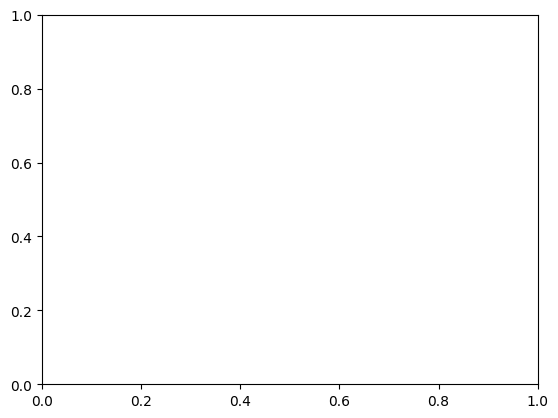

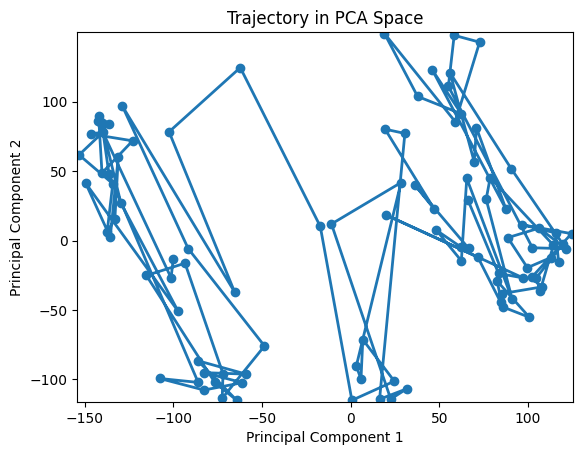

In [29]:
#####                           #####
#####  THIS IS FOR 2D ANIMATION ##### 
#####                           #####

# This script plots the time evolution of the PAC space as a gif

# Verify your data is loaded correctly
print(pca_projections.shape)  # Should be (N_frames, 2)
print(pca_projections[:5])  # Print the first 5 points to check

# Choose every 100th frame
frame_step = 100
frames_to_use = pca_projections[::frame_step]  # Select every 100th frame

print(f"Number of frames used: {frames_to_use.shape[0]}")

# Set up the figure and axis
fig, ax = plt.subplots()

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(np.min(frames_to_use[:, 0]) - 1, np.max(frames_to_use[:, 0]) + 1)
ax.set_ylim(np.min(frames_to_use[:, 1]) - 1, np.max(frames_to_use[:, 1]) + 1)

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Trajectory in PCA Space')

# Line object to update during animation
line, = ax.plot([], [], 'o-', lw=2)

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function: this is called sequentially
def animate(i):
    line.set_data(frames_to_use[:i+1, 0], frames_to_use[:i+1, 1])
    return line,

# Create animation using the selected frames
ani = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(frames_to_use), interval=50, blit=True
)

# Save animation (choose appropriate format)
ani.save('pca_trajectory.gif', writer='pillow', dpi=300)  # Save as GIF


(10002, 3)
[[ 66.11833741  29.3175623   85.52039975]
 [ 65.40027907  25.40658526  86.79761195]
 [ 69.2787495   -3.84372201 100.08024233]
 [ 58.8291868   26.33487897  88.35185437]
 [ 62.59279178  13.20538031  97.03187624]]
Number of frames used: 101


/var/folders/q9/3_m1wtjn48qcqpr12gdycyhc0000gn/T/ipykernel_11682/1589596991.py:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/q9/3_m1wtjn48qcqpr12gdycyhc0000gn/T/ipykernel_11682/1589596991.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



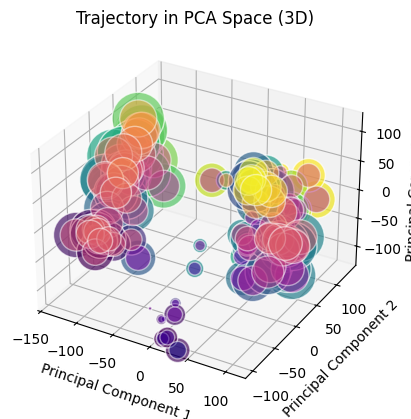

In [30]:
#####                           #####
#####  THIS IS FOR 3D ANIMATION #####
#####                           #####

# Verify your data is loaded correctly
print(pca_projections.shape)  # Should be (N_frames, 2)
print(pca_projections[:5])  # Print the first 5 points to check

frame_step = 100  # Frame skipping interval

# Select every 100th frame
frames_to_use = pca_projections[::frame_step]

# Use the first three principal components for 3D plotting
x = frames_to_use[:, 0]  # PC1
y = frames_to_use[:, 1]  # PC2
z = frames_to_use[:, 2]  # PC3

# Define gradients
color_gradient1 = y  # Color by PC2
color_gradient2 = z  # Color by PC3
size_gradient = x    # Size by PC1

# Handle potential negative sizes by scaling size_gradient appropriately
size_scale = np.abs(size_gradient) * 10  # Scale sizes, keeping absolute values

# Normalize color gradients for colormaps
norm_color1 = Normalize(vmin=np.min(color_gradient1), vmax=np.max(color_gradient1))
cmap_color1 = cm.get_cmap('viridis')  # Choose a colormap for color gradient 1

norm_color2 = Normalize(vmin=np.min(color_gradient2), vmax=np.max(color_gradient2))
cmap_color2 = cm.get_cmap('plasma')   # Choose a colormap for color gradient 2

# Check the new number of frames used
print(f"Number of frames used: {frames_to_use.shape[0]}")

# Set up the figure and axis for 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialization function: plot the background of each frame
def init():
    ax.cla()  # Clear the axis to reset the plot
    ax.set_xlim(np.min(x) - 1, np.max(x) + 1)
    ax.set_ylim(np.min(y) - 1, np.max(y) + 1)
    ax.set_zlim(np.min(z) - 1, np.max(z) + 1)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('Trajectory in PCA Space (3D)')
    return []

# Animation function: this is called sequentially
def animate(i):
    ax.cla()  # Clear the axis to reset the plot
    
    # Create a scatter plot with color and size gradients
    sc = ax.scatter(x[:i+1], y[:i+1], z[:i+1],
                    c=color_gradient1[:i+1], s=size_scale[:i+1],
                    cmap=cmap_color1, norm=norm_color1, alpha=0.7, edgecolor='w')
    
    # Overlay an additional scatter plot for the second color gradient
    sc2 = ax.scatter(x[:i+1], y[:i+1], z[:i+1],
                     c=color_gradient2[:i+1], s=0.5*size_scale[:i+1],  # Adjust size for visibility
                     cmap=cmap_color2, norm=norm_color2, alpha=0.5, edgecolor='w')
    
    # Update axis limits
    ax.set_xlim(np.min(x) - 1, np.max(x) + 1)
    ax.set_ylim(np.min(y) - 1, np.max(y) + 1)
    ax.set_zlim(np.min(z) - 1, np.max(z) + 1)
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('Trajectory in PCA Space (3D)')
    
    return [sc, sc2]

# Create animation using the selected frames
ani = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(frames_to_use), interval=50, blit=True
)

# Save animation (choose appropriate format)
ani.save('pca_trajectory_3d_colored_gradient.gif', writer='pillow', dpi=300)  # Save as GIF
